# ETL for the Host dimension

In this dimension we hold information relative to airbnb hosts.

![Host schema](../images/host_schema.png)

**Hierarchies and data granularity**

The only hierarchical relationship in this dimension is `country` < `continent`. There wasn't a way to make it more fine-grained since the host location data we had was quite heterogenous, more often than not cointaining only the host's 
country.

One way of having more fine-grained information would be to have the host fill in a form at the moment of registration with fixed slots for county, district, city, country, etc. That would also greatly facilitate the pre-processing and make it more reproducible.

![ETL Host](../images/ETL_host.png)

In [1]:
# Libraries
import psycopg2 as pg
import pandas as pd
import os
import re
import pycountry_convert as pc
import matplotlib.pyplot as plt
import datetime
import math
import numpy as np
import psycopg2.extras
import seaborn as sns
import pandas.io.sql as sqlio

## Read csv files

In [2]:
# Main dataset
df = pd.read_csv("../data/listings_al.csv")
# Dataset for countries gdp.
# Source:  https://data.worldbank.org/indicator/ny.gdp.pcap.cd
df_gdp = pd.read_csv('../data/GDP per capita (worldbank).csv')

C:\Users\joao_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## EDA and missing data

Singling out the columns of interest for this dimension, we analyse the distribution of missing values.

In [3]:
def missing_data(df, columns):
    """Calculates the amount of missing data in given DataFrame's selected columns"""
    df_graph = df[columns]
    # missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')

                    Total   Percent
host_response_time   1691  0.098497
host_location          21  0.001223
host_verifications      0  0.000000
host_is_superhost       0  0.000000
host_since              0  0.000000
host_name               0  0.000000


Text(0.5, 1.0, 'Host dimension missing data')

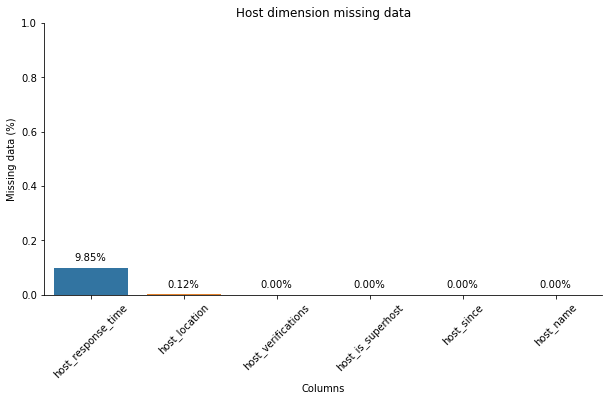

In [4]:
columns = [
'host_name',
'host_since',
'host_location',
'host_response_time',
'host_is_superhost',
'host_verifications'
]
ax = missing_data(df,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Missing data (%)')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Host dimension missing data')

Looking at the missing data we realize that it's reasonable to ignore the records of hosts lacking `location`, since it only corresponds to 0.12% of the whole dataset and the main focus of this analysis is based on the host location. 

As for `response time`, we have 1691 missing values. Paradoxically, the fact that there isn't any information about whether the host is accessible is actually informative in some sense. Thus, all records lacking host_response_time values will be considered as if the response time is "Unknown".



## Transformation methods

In [5]:
# Check for missing values:
def is_nan(x):
    return (x != x)

In [6]:
def get_host_name(name):
    #If there is a name, return it
    if is_nan(name): return "Unknown"
    return name

In [7]:
def get_host_membership_duration(date):
    #date is a string with the date as YYYY-MM-DD

    if is_nan(date): return "Unknown"
    #get current year
    now = datetime.datetime.now()
    
    #calculate membership duration
    membership_time = now.year - int(date[0:4])
    if membership_time > 10: return "Member for more than 10 years"
    if membership_time > 5: return "Member for more than 5 years"
    if membership_time > 2: return "Member for more than 2 years"
    if membership_time >= 1: return "Member for more than 1 year"
    if membership_time < 1: return "Member for less than 1 year"

As we discussed previously, all host records who don't have a known location will be ignored - `None` lines will be later removed in preprocessing.

In [8]:
def get_host_country(location):
    #location is a string with the host location -- may not have country
    location = str(location)
    if re.search('po.*tugal', location, re.IGNORECASE): return "Portugal"
    if re.search('lisbo', location, re.IGNORECASE): return "Portugal"
    if re.search('PT', location): return "Portugal"
    if re.search('spain', location, re.IGNORECASE): return "Spain"
    if re.search('ES', location): return "Spain"
    if re.search('madrid', location, re.IGNORECASE): return "Spain"
    if re.search('united kingdom', location, re.IGNORECASE): return "United Kingdom"
    if re.search('UK', location): return "United Kingdom"
    if re.search('GB', location): return "United Kingdom"
    if re.search('ireland', location, re.IGNORECASE): return "United Kingdom"
    if re.search('denmark', location, re.IGNORECASE): return "Denmark"
    if re.search('netherlands', location, re.IGNORECASE): return "Netherlands"
    if re.search('NL', location): return "Netherlands"
    if re.search('germany', location, re.IGNORECASE): return "Germany"
    if re.search('DE', location): return "Germany"
    if re.search('belgium', location, re.IGNORECASE): return "Belgium"
    if re.search('united states', location, re.IGNORECASE): return "United States"
    if re.search('US', location): return "United States"
    if re.search('canada', location, re.IGNORECASE): return "Canada"
    if re.search('france', location, re.IGNORECASE): return "France"
    if re.search('FR', location): return "France"
    if re.search('italy', location, re.IGNORECASE): return "Italy"
    if re.search('IT', location): return "Italy"
    if re.search('switzerland', location, re.IGNORECASE): return "Switzerland"
    if re.search('sweden', location, re.IGNORECASE): return "Sweden"
    if re.search('poland', location, re.IGNORECASE): return "Poland"
    if re.search('finland', location, re.IGNORECASE): return "Finland"
    if re.search('serbia', location, re.IGNORECASE): return "Serbia"
    if re.search('austria', location, re.IGNORECASE): return "Austria"
    if re.search('iceland', location, re.IGNORECASE): return "Iceland"
    if re.search('norway', location, re.IGNORECASE): return "Norway"
    if re.search('china', location, re.IGNORECASE): return "China"
    if re.search('angola', location, re.IGNORECASE): return "Angola"
    if re.search('australia', location, re.IGNORECASE): return "Australia"
    if re.search('brazil', location, re.IGNORECASE): return "Brazil"
    if re.search('BR', location): return "Brazil"
    if re.search('peru', location, re.IGNORECASE): return "Peru"
    if re.search('sri lanka', location, re.IGNORECASE): return "Sri Lanka"
    if re.search('vietnam', location, re.IGNORECASE): return "Vietnam"
    if re.search('united arab emirates', location, re.IGNORECASE): return "United Arab Emirates"
    if re.search('south africa', location, re.IGNORECASE): return "South Africa"
    if re.search('qatar', location, re.IGNORECASE): return "Qatar"
    if re.search('japan', location, re.IGNORECASE): return "Japan"
    if re.search('turkey', location, re.IGNORECASE): return "Turkey"
    else: return None

One thing to keep in mind is that this method for identification of the host's country is not the most adequate, since it is not very generalizable to new data. In order for this method to work safely for all new data, an extended 'database' of countries would be needed. Here we made an effort to cover the most common countries in the dataset, but did not extend it much in order to preserve performance.

One alternative that we pursued was using the `pycountry` library, but since it was very inefficient (for each record it would go through all countries in the library!) we decided that for the purpose of this work the method above would be satisfatory.

In [9]:
def get_host_continent(country):
    if country == None: return None
    
    continents_dic = {
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    }
    
    # Acquire the country code
    country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
    # Convert country code to continent code; use dictionary to return continent name
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    
    return continents_dic[continent_name]

In [10]:
def get_host_country_gdp(country):
    if country == None: return None
    
    # Always get latest (most updated) gdp available in the gdp dataset - last column
    # The level of detail required here is not very high, since we will use bins
    # to characterize the countries' wealth
    dict_gdp = pd.Series(df_gdp.iloc[:,-1].values, index=df_gdp['Country Name']).to_dict()
    
    if country not in dict_gdp.keys(): return "Unknown"
    
    gdp = dict_gdp[country]
    if gdp <= 20000  : return "Below 20k"
    if gdp <= 35000  : return "20k - 35k"
    if gdp <= 50000  : return "35k - 50k"
    if gdp > 50000 : return "Above 50k"
    else: return None

In [11]:
def get_host_response_time(response_time):
    #if there is a response_time, return it
    if is_nan(response_time): return "Unknown"
    return response_time

In [12]:
def get_host_is_superhost(is_superhost):
    if is_superhost == 't': return "Superhost"
    if is_superhost == 'f': return "Not Superhost"
    else: return None

In [13]:
def get_host_identity_verified(identity):
    if identity == 't': return "Verified"
    if identity == 'f': return "Unverified"
    else: return None

### Create clean dataframe

We will now use the methods described above to create each column of the dimension, extracting the data from the original dataset `df`.

In [14]:
listing_id = [i for i in df['id']]
host_id = [h for h in df['host_id']]
names = [n for n in df['host_name']]
membership_duration = [get_host_membership_duration(d) for d in df['host_since']]
country = [get_host_country(l) for l in df['host_location']]
continent = [get_host_continent(c) for c in country]
gdp = [get_host_country_gdp(c) for c in country]
response_time = [get_host_response_time(t) for t in df['host_response_time']]
superhost = [get_host_is_superhost(b) for b in df['host_is_superhost']]
identity_verified = [get_host_identity_verified(i) for i in df['host_identity_verified']]

ValueError: invalid literal for int() with base 10: '4/12'

In [ ]:
columns = ['listing_id','host_id','host_name', 'membership_duration','host_country', 'host_continent', 
           'host_country_gdp', 'host_response_time', 'host_is_superhost', 'host_is_verified']

# Create dataframe
df_host_dimension = pd.DataFrame(np.stack((listing_id, host_id, names, membership_duration, country, 
                                           continent, gdp, response_time, superhost, 
                                           identity_verified),axis=-1), columns = columns)
# Dataframe shape (rows, columns)
df_host_dimension.shape

**Remove records with null values:**

In [ ]:
def delete_null_rows(df,columns):
    """Removes all records with any empty cells from input DataFrame"""
    processed_df = df[columns].copy()
    total_rows = processed_df.shape[0]
    delete_rows = []
    
    if processed_df.isnull().values.any(): # if there are any null values in DataFrame, process DataFrame
        for index, row in enumerate(processed_df.itertuples(), start = 0):
            if (pd.Series(row).isnull().values.any()): # if row has any null value
                delete_rows.append(index) # add row index to delete list
    
    processed_df.drop(df.index[delete_rows], inplace = True) # delete rows fr
    processed_df = processed_df.reset_index().drop('index', axis = 1)
    print('DataFrame contains {} rows. Deleted {} rows ({}% of total rows)'.format(processed_df.shape[0], len(delete_rows), round(len(delete_rows)*100/total_rows, 2)))
    return processed_df

In [ ]:
df_host_dimension = delete_null_rows(df_host_dimension, columns)

**Remove duplicates:**

In [ ]:
columns = ['host_id','host_name', 'membership_duration','host_country', 'host_continent', 
           'host_country_gdp', 'host_response_time', 'host_is_superhost', 'host_is_verified']

host_dimension_processed = df_host_dimension[columns]
host_dimension_processed = host_dimension_processed.drop_duplicates()
host_dimension_processed = host_dimension_processed.reset_index().drop('index', axis = 1)
host_dimension_processed.index += 1

host_dimension_processed.head()

## Attributing dimension keys to facts

We have a one-to-many relationship between `host ids` and `listing ids`. We create this table to keep track of the relationship between every fact in the fact table (PK - listing_id) and its respective host (FK - host_id).

In [ ]:
df_mapping = pd.DataFrame(columns=['listing_id', 'host_id'])
df_mapping['listing_id'] = df_host_dimension['listing_id']
df_mapping['host_id'] = df_host_dimension['host_id']

df_mapping.head()

In [ ]:
df_mapping.to_csv('../processed_dt/df_listings_host.csv')

### Load Host dimension

**Test connection**

Load database connection settings

In [ ]:
from db_connection import dbconnection 

Test connection

In [ ]:
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
conn.close()

**Create or delete dimension**

In [ ]:
delete_table = """
DROP TABLE IF EXISTS Host CASCADE;
"""

create_table = """
CREATE TABLE Host (
    HOST_ID INT PRIMARY KEY NOT NULL,
    HOST_NAME VARCHAR(40) NOT NULL,
    MEMBERSHIP_DURATION VARCHAR(40) CHECK (MEMBERSHIP_DURATION in ('Member for more than 10 years','Member for more than 5 years','Member for more than 2 years','Member for more than 1 year','Member for less than 1 year', 'Unknown')) NOT NULL,
    HOST_COUNTRY VARCHAR(20) NOT NULL,
    HOST_CONTINENT VARCHAR(20) CHECK (HOST_CONTINENT in ('Europe','North America','South America','Asia','Australia','Africa')) NOT NULL,
    HOST_COUNTRY_GDP VARCHAR(20) CHECK (HOST_COUNTRY_GDP in ('Below 20k','20k - 35k','35k - 50k','Above 50k')) NOT NULL,
    HOST_RESPONSE_TIME VARCHAR(20) CHECK (HOST_RESPONSE_TIME in ('within an hour','within a few hours','within a day','a few days or more','Unknown')) NOT NULL,
    HOST_IS_SUPERHOST VARCHAR(20) CHECK (HOST_IS_SUPERHOST in ('Superhost','Not Superhost')) NOT NULL,
    HOST_IS_VERIFIED VARCHAR(20) CHECK (HOST_IS_VERIFIED in ('Verified','Unverified')) NOT NULL
    )
"""

In [ ]:
def excuteSingleSQLstatement(sql, host, database, user, password,gssencmode):
    conn = pg.connect(host=host,database=database, user=user, password=password,sslmode = sslmode,gssencmode=gssencmode)
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

In [ ]:
#excuteSingleSQLstatement(delete_table, dbconnection.server_host, dbconnection.dbname, dbconnection.dbusername, dbconnection.dbpassword,gssencmode = dbconnection.gssencmode)
#excuteSingleSQLstatement(create_table, dbconnection.server_host, dbconnection.dbname, dbconnection.dbusername, dbconnection.dbpassword,gssencmode = dbconnection.gssencmode)

**Inserting the data**

We will be inserting the data from the dataframe `host_dimension_processed`, but first checking whether that information is already in the database.

In [ ]:
# Useful methods

def query_table(conn, table_name):
    """Returns DataFrame with queried database table"""
    sql = "select * from {}".format(table_name)
    #return dataframe
    return sqlio.read_sql_query(sql, conn)

def get_data_to_insert(df1, df2, columns):
    #Check if data of df1's given columns is in df2
    #Only works if df1 and df2 have the same columns
    return df1[~df1[columns].apply(tuple,1).isin(df2[columns].apply(tuple,1))]

def insert_data(df, table_name, conn):
    # Method for bulk insert
    
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        pg.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except pg.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

1. Query Database

In [ ]:
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
df_sql = query_table(conn, 'Host')
conn.close()
df_sql.drop(['host_id'], axis=1, inplace=True)
df_sql.head()

2. Cross-Validate if data exists on DB

In [ ]:
columns = ['host_name', 'membership_duration','host_country', 'host_continent', 
           'host_country_gdp', 'host_response_time', 'host_is_superhost', 'host_is_verified']

df_etl = get_data_to_insert(host_dimension_processed, df_sql, columns=columns)
df_etl.head()

3. Insert new data

In [ ]:
if len(df_etl) > 0:
    table_name = 'Host'
    conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
    success = insert_data(df_etl,table_name, conn)
    conn.close()
    if success == True: print('Data inserted succefully')
else: print('No data to insert')